# Notebook Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/itau/

/content/drive/.shortcut-targets-by-id/1aUC5RchZtFpeGyPvJo-XMSlXMbwngk3G/itau


In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate ,GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt
from dataset.dataset import Dataset

In [6]:
ds = Dataset()

In [7]:
ds.load_data()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Model

## Functions version 0

In [ ]:
def get_features_customers(customers_df):
  features_customers = ['id','Principalidad','Segmento_consumidor','Recibe_sueldo_en_cuenta','Meses_antiguedad']
  features_customers_df = customers_df[features_customers].copy()
  features_customers_df.at[:,'antiquity_1_year'] = [(not (x == 'Menos de 1 año'))*1 for x in features_customers_df.Meses_antiguedad ]
  features_customers_df.at[:,'segmento_A'] =[(x=='A')*1 for x in features_customers_df.Segmento_consumidor]
  principalidad_dummies = get_dummies_principalidad(features_customers_df)
  features_customers_df = features_customers_df.merge(principalidad_dummies, how='left', left_on='id', right_index = True)
  features_customers_df.drop(columns=['Meses_antiguedad','Segmento_consumidor','Principalidad'],inplace=True)
  return features_customers_df

def get_dummies_principalidad(features_customers_df_o):
  features_customers_df = features_customers_df_o.copy()
  features_customers_df = features_customers_df.astype({'Principalidad':'object'})
  features_customers_df.Principalidad.fillna('N',inplace=True)
  principalidad_dummies = pd.get_dummies(features_customers_df.set_index('id').Principalidad,prefix='Prin_')
  return principalidad_dummies
  

def get_info_months(df_transactions_product, list_months, previous_months = True):
  mask_last =  df_transactions_product["Periodo"].apply(lambda x: x in list_months)
  df_last = pd.DataFrame(data = list(df_transactions_product[mask_last].id.unique()), columns = ['id'])
  name_col = 'last_n_months_bought' if previous_months else 'last_n_months_year_bought'
  df_last.at[:, name_col] = 1
  return df_last

def get_data_transactions(features_customers_df, df_transactions_product, list_last_months, list_last_year_months):
  df_last_months = get_info_months(df_transactions_product, list_last_months)
  df_last_months_year = get_info_months(df_transactions_product, list_last_year_months, previous_months= False)
  data_transactions = features_customers_df.merge(df_last_months, how='left',on='id')
  data_transactions = data_transactions.merge(df_last_months_year, how='left',on='id')
  return data_transactions

def get_df_transactions_product(transactions_df_o, product):
  mask_product = (transactions_df_o["Producto-Tipo"] == product)
  df_transactions_product = transactions_df_o[mask_product].copy()
  return df_transactions_product

def get_data_campains(campains_df, data_out_campains, list_3_months, product):
  mask_campain_product = (campains_df["Producto-Tipo"] == product)
  campain_product_df = campains_df[mask_campain_product].copy()
  mask_campains =  campain_product_df["Periodo"].apply(lambda x: x in list_3_months)
  df_campains = pd.DataFrame(data = list(campain_product_df[mask_campains].id.unique()), columns = ['id'])
  df_campains.at[:,'campain'] = 1
  data = data_out_campains.merge(df_campains, how='left',on='id')
  return data

def get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train):
  mask_labels =  df_transactions_product["Periodo"].apply(lambda x: x in list_3_months_labels_train)
  df_labels = pd.DataFrame(data = list(df_transactions_product[mask_labels].id.unique()), columns = ['id'])
  df_labels.at[:,'labels'] = 1
  ids_df = pd.DataFrame(features_customers_df.id)
  df_labels = ids_df.merge(df_labels, how='left', on = 'id')
  df_labels.labels.fillna(0,inplace=True)
  return df_labels

def fill_na_data(data_o,campain =True):
  data = data_o.copy()
  data.last_n_months_bought.fillna(0,inplace=True)
  data.last_n_months_year_bought.fillna(0,inplace=True)
  if campain:
    data.campain.fillna(0,inplace=True)
  return data

## Grid search random forest

In [ ]:
list_3_months_labels_train = [202005,202006,202007]
list_3_last_months_train = [202002,202003,202004]
list_last_year_3_months_train = [201905,201906,201907]

list_3_months_campain_test = [202008,202009,202010]
list_3_last_months_test = [202005,202006,202007]
list_last_year_3_months_test = [201908,201909,201910]

products  = ["A-A", "B-B", "C-D", "D-E", "E-E"]
dic_deltas = {"A-A":-0.01, "B-B":-0.01, "C-D":-0.01, "D-E":0.0, "E-E":-0.01}
dic_epsilons = {"A-A":0.1, "B-B":0.2, "C-D":0.4, "D-E":0.5, "E-E":0.3}
define_df_entrega = True
features_customers_df = get_features_customers(ds.customers_df)
for product in products:
  df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)
  data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product,
                                                  list_3_last_months_train, list_last_year_3_months_train)
  data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product,
                                                  list_3_last_months_test, list_last_year_3_months_test)

  if products in ["A-A"]:
    data_train_nas = get_data_campains(ds.campains_train_df, data_train_out_campains, list_3_months_labels_train, product)
    data_test_nas  = get_data_campains(ds.campains_test_df, data_test_out_campains, list_3_months_campain_test, product)
    data_train = fill_na_data(data_train_nas)
    data_test = fill_na_data(data_test_nas)
  else:
    data_train_nas = data_train_out_campains
    data_test_nas = data_test_out_campains
    data_train = fill_na_data(data_train_nas,campain =False)
    data_test = fill_na_data(data_test_nas,campain = False)
  
  if product != "B-B":
    mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201904)
    mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201907)
  else:
    mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201907)
    mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201910)
  
  months_features_train = pd.pivot_table(df_transactions_product[mask_train],index='id',values='Monto',columns='Periodo',fill_value=0)
  months_features_test = pd.pivot_table(df_transactions_product[mask_test],index='id',values='Monto',columns='Periodo',fill_value=0)
  months_features_train = (months_features_train!=0)*1
  months_features_test = (months_features_test!=0)*1
  ids_months = pd.DataFrame(data = data_test.id)
  months_features_train = ids_months.merge(months_features_train.reset_index(),how ='left', on ='id')
  months_features_test = ids_months.merge(months_features_test.reset_index(),how ='left', on ='id')
  months_features_train.fillna(0,inplace=True)
  months_features_test.fillna(0,inplace=True)
  data_train = data_train.merge(months_features_train,how='left',on='id')
  data_test = data_test.merge(months_features_test,how='left',on='id')

  df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
  X_train = data_train.drop(columns='id')
  X_test  = data_test.drop(columns='id')
  y = df_labels['labels']
  scoring = 'roc_auc'
  dic_grid_params = { "A-A": {'n_estimators': [100,150,200],'max_depth': [15,20,25]},
                      "B-B": {'n_estimators': [40,50,75],'max_depth': [25,30,35]}, 
                      "C-D": {'n_estimators': [100,150,200],'max_depth': [25,30,35]},
                      "D-E": {'n_estimators': [100,150,200],'max_depth': [15,20,25]},
                      "E-E": {'n_estimators': [100,150,200],'max_depth': [15,20,25]}}
  model = RandomForestClassifier()
  grid_cv = GridSearchCV(model, param_grid = dic_grid_params[product] , scoring=scoring)
  grid_cv.fit(X_train,y)
  percen = (1-sum(df_labels.labels)/len(df_labels))
  print('proporcion test',sum(df_labels.labels)/len(df_labels))
  q = np.quantile(grid_cv.predict_proba(X_test)[:,1], percen) + dic_deltas[product]
  print(q,product)
  print(grid_cv.best_params_)
  print(grid_cv.best_score_)
  if define_df_entrega:
    ids_entrega = pd.DataFrame(data = data_test.id)
    define_df_entrega = False
  ids_entrega.at[:,product] = [(x>q)*1 +dic_epsilons[product]  for x in grid_cv.predict_proba(X_test)[:,1] ]
  print('proporcion prediccion', sum(ids_entrega[product]>1)/len(ids_entrega))
  print('***********************************************************************************')

proporcion test 0.022391531198531538
0.07685777965303421 A-A
{'max_depth': 15, 'n_estimators': 100}
0.6344205967206942
proporcion prediccion 0.02505689033052968
***********************************************************************************
proporcion test 0.08969184928148455
0.12686978115927516 B-B
{'max_depth': 35, 'n_estimators': 75}
0.5629204080494542
proporcion prediccion 0.11821873546310616
***********************************************************************************
proporcion test 0.20674134701215754
0.5052028905778956 C-D
{'max_depth': 25, 'n_estimators': 150}
0.9428743415543993
proporcion prediccion 0.20752083883377964
***********************************************************************************
proporcion test 0.2960937401777744
0.3279196065158082 D-E
{'max_depth': 15, 'n_estimators': 200}
0.867908342679004
proporcion prediccion 0.29606859528030277
***********************************************************************************
proporcion test 0.0700662568

## Random Forest features importances

proporcion test 0.022391531198531538
0.08482662835071679 A-A
auc in train (do not metric for model) 0.778991472542426
proporcion prediccion 0.024931165843171274


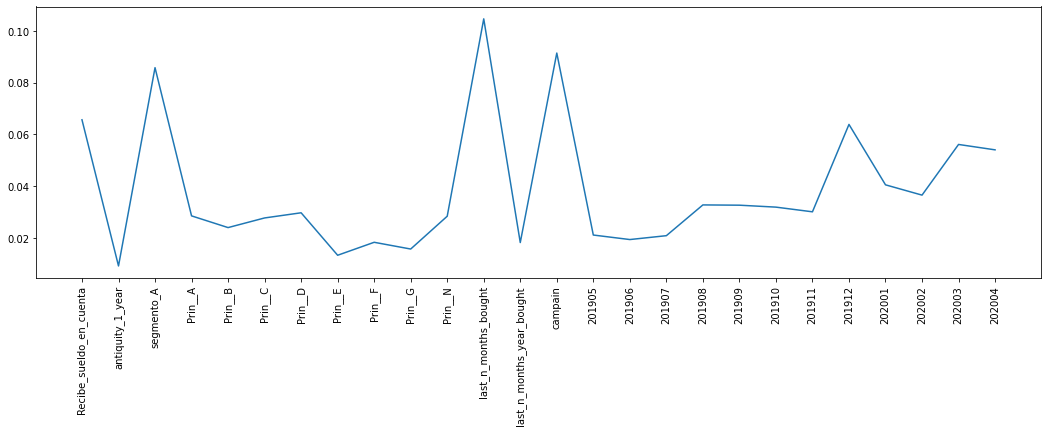

***********************************************************************************
***********************************************************************************
proporcion test 0.08969184928148455
0.1287866473907242 B-B
auc in train (do not metric for model) 0.6660764730490794
proporcion prediccion 0.11268685801933642


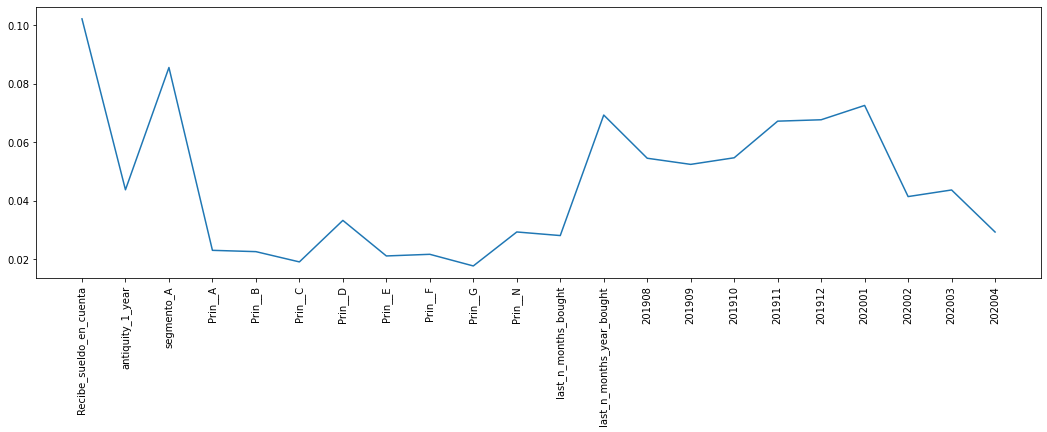

***********************************************************************************
***********************************************************************************
proporcion test 0.20674134701215754
0.55 C-D
auc in train (do not metric for model) 0.9832290860046653
proporcion prediccion 0.2074076867951571


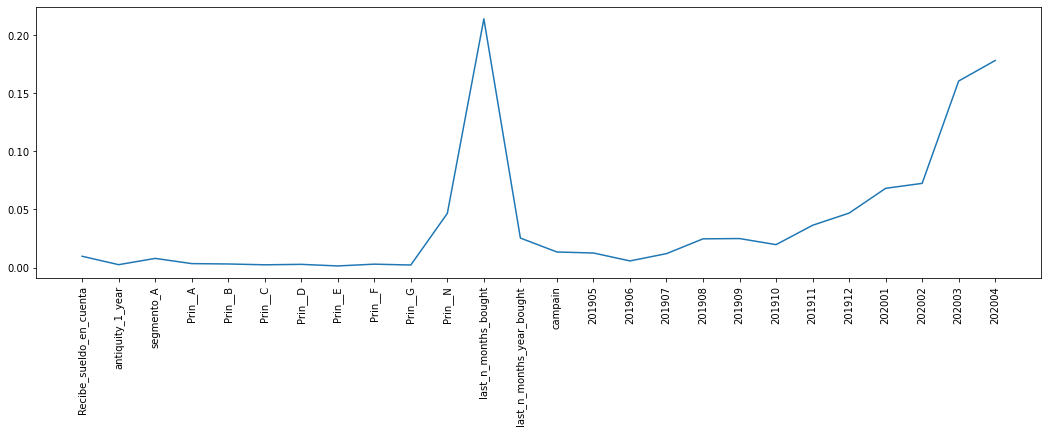

***********************************************************************************
***********************************************************************************
proporcion test 0.2960937401777744
0.33273459644861014 D-E
auc in train (do not metric for model) 0.8896260330866014
proporcion prediccion 0.2960308779340952


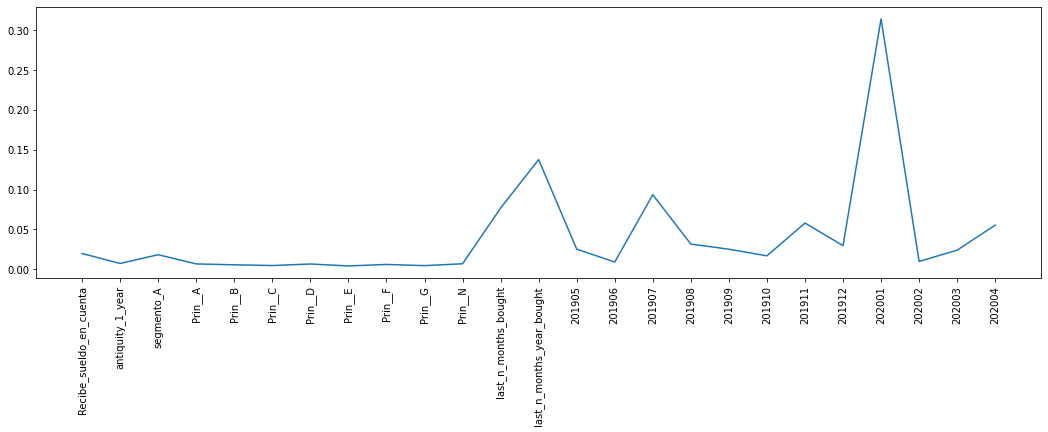

***********************************************************************************
***********************************************************************************
proporcion test 0.07006625680483788
0.21946707664096315 E-E
auc in train (do not metric for model) 0.8813396491758166
proporcion prediccion 0.07283219552672274


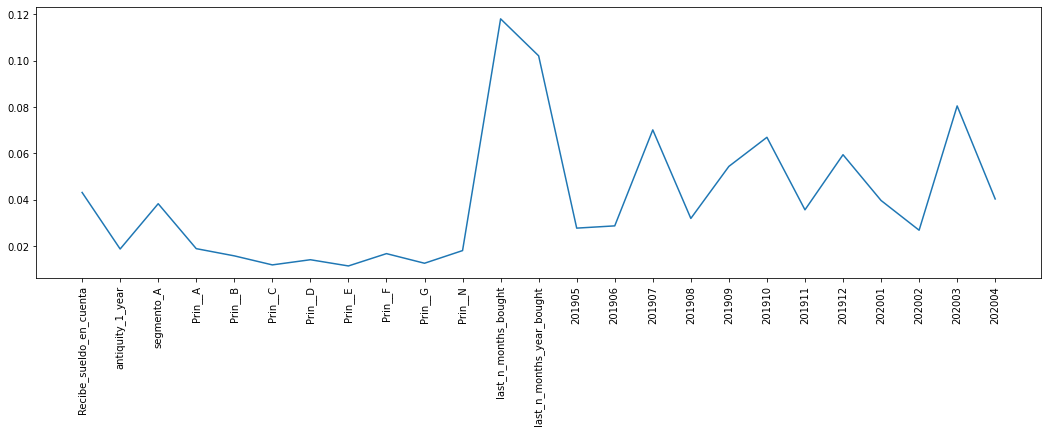

***********************************************************************************
***********************************************************************************


In [ ]:
list_3_months_labels_train = [202005,202006,202007]
list_3_last_months_train = [202002,202003,202004]
list_last_year_3_months_train = [201905,201906,201907]

list_3_months_campain_test = [202008,202009,202010]
list_3_last_months_test = [202005,202006,202007]
list_last_year_3_months_test = [201908,201909,201910]

products  = ["A-A", "B-B", "C-D", "D-E", "E-E"]
dic_deltas = {"A-A":-0.01, "B-B":-0.01, "C-D":-0.01, "D-E":0.0, "E-E":-0.01}
dic_epsilons = {"A-A":0.1, "B-B":0.2, "C-D":0.4, "D-E":0.5, "E-E":0.3}
define_df_entrega = True
features_customers_df = get_features_customers(ds.customers_df)
for product in products:
  df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)
  data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product,
                                                  list_3_last_months_train, list_last_year_3_months_train)
  data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product,
                                                  list_3_last_months_test, list_last_year_3_months_test)

  if product in ["A-A","C-D"]:
    data_train_nas = get_data_campains(ds.campains_train_df, data_train_out_campains, list_3_months_labels_train, product)
    data_test_nas  = get_data_campains(ds.campains_test_df, data_test_out_campains, list_3_months_campain_test, product)
    data_train = fill_na_data(data_train_nas)
    data_test = fill_na_data(data_test_nas)
  else:
    data_train_nas = data_train_out_campains
    data_test_nas = data_test_out_campains
    data_train = fill_na_data(data_train_nas,campain =False)
    data_test = fill_na_data(data_test_nas,campain = False)
  
  if product != "B-B":
    mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201904)
    mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201907)
  else:
    mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201907)
    mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201910)
  
  months_features_train = pd.pivot_table(df_transactions_product[mask_train],index='id',values='Monto',columns='Periodo',fill_value=0)
  months_features_test = pd.pivot_table(df_transactions_product[mask_test],index='id',values='Monto',columns='Periodo',fill_value=0)
  months_features_train = (months_features_train!=0)*1
  months_features_test = (months_features_test!=0)*1
  ids_months = pd.DataFrame(data = data_test.id)
  months_features_train = ids_months.merge(months_features_train.reset_index(),how ='left', on ='id')
  months_features_test = ids_months.merge(months_features_test.reset_index(),how ='left', on ='id')
  months_features_train.fillna(0,inplace=True)
  months_features_test.fillna(0,inplace=True)
  data_train = data_train.merge(months_features_train,how='left',on='id')
  data_test = data_test.merge(months_features_test,how='left',on='id')

  df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
  X_train = data_train.drop(columns='id')
  X_test  = data_test.drop(columns='id')
  y = df_labels['labels']
  scoring = 'roc_auc'
  dic_grid_params = { "A-A": {'n_estimators': 100,'max_depth': 15},
                      "B-B": {'n_estimators': 75,'max_depth': 35}, 
                      "C-D": {'n_estimators': 150,'max_depth': 25},
                      "D-E": {'n_estimators': 200,'max_depth': 15},
                      "E-E": {'n_estimators': 100,'max_depth': 15}}
  model = RandomForestClassifier(n_estimators=dic_grid_params[product]['n_estimators'], max_depth=dic_grid_params[product]['max_depth'])
  model.fit(X_train,y)
  percen = (1-sum(df_labels.labels)/len(df_labels))
  print('proporcion test',sum(df_labels.labels)/len(df_labels))
  q = np.quantile(model.predict_proba(X_test)[:,1], percen) + dic_deltas[product]
  print(q,product)
  #print(model.best_params_)
  #print(grid_cv.best_score_)
  print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))
  if define_df_entrega:
    ids_entrega = pd.DataFrame(data = data_test.id)
    define_df_entrega = False
  ids_entrega.at[:,product] = [(x>q)*1 +dic_epsilons[product]  for x in model.predict_proba(X_test)[:,1] ]
  print('proporcion prediccion', sum(ids_entrega[product]>1)/len(ids_entrega))
  plt.figure(figsize=(18,5))
  plt.plot(model.feature_importances_)
  plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
  plt.show()
  print('***********************************************************************************')
  print('***********************************************************************************')

## Functions version 1

In [8]:
def get_features_customers(customers_df,features_customers):
  features_customers_df = customers_df[features_customers].copy()
  if 'Meses_antiguedad' in  features_customers_df.columns:
    features_customers_df.at[:,'antiquity_1_year'] = [(not (x == 'Menos de 1 año'))*1 for x in features_customers_df.Meses_antiguedad ]
  features_customers_df.at[:,'segmento_A'] =[(x=='A')*1 for x in features_customers_df.Segmento_consumidor]
  cols = ['Segmento_consumidor']
  cols = cols + ['Meses_antiguedad'] if 'Meses_antiguedad' in  features_customers_df.columns else cols
  features_customers_df.drop(columns= cols,inplace=True)
  return features_customers_df

def get_dummies_principalidad(features_customers_df_o):
  features_customers_df = features_customers_df_o.copy()
  features_customers_df = features_customers_df.astype({'Principalidad':'object'})
  features_customers_df.Principalidad.fillna('N',inplace=True)
  principalidad_dummies = pd.get_dummies(features_customers_df.set_index('id').Principalidad,prefix='Prin_')
  return principalidad_dummies
  
def get_months_features(df_transactions_product, data_id, mask):
  months_features = pd.pivot_table(df_transactions_product[mask],index='id',values='Monto',columns='Periodo',fill_value=0)
  months_features = (months_features!=0)*1
  ids_months = pd.DataFrame(data = data_test.id)
  months_features = ids_months.merge(months_features.reset_index(),how ='left', on ='id')
  months_features.fillna(0,inplace=True)
  return months_features

def get_info_months(df_transactions_product, list_months, previous_months = True):
  mask_last =  df_transactions_product["Periodo"].apply(lambda x: x in list_months)
  df_last = pd.DataFrame(data = list(df_transactions_product[mask_last].id.unique()), columns = ['id'])
  name_col = 'last_n_months_bought' if previous_months else 'last_n_months_year_bought'
  df_last.at[:, name_col] = 1
  return df_last

def get_data_transactions(features_customers_df, df_transactions_product, list_last_months =[], list_last_year_months=[]):
  if (list_last_months == []) and (list_last_year_months != []):
    df_last_months_year = get_info_months(df_transactions_product, list_last_year_months, previous_months= False)
    data_transactions = features_customers_df.merge(df_last_months_year, how='left',on='id')
  elif (list_last_months != []) and (list_last_year_months == []):
    df_last_months = get_info_months(df_transactions_product, list_last_months, previous_months= False)
    data_transactions = features_customers_df.merge(df_last_months, how='left',on='id')
  elif (list_last_months != []) and (list_last_year_months != []):
    df_last_months = get_info_months(df_transactions_product, list_last_months)
    df_last_months_year = get_info_months(df_transactions_product, list_last_year_months, previous_months= False)
    data_transactions = features_customers_df.merge(df_last_months, how='left',on='id')
    data_transactions = data_transactions.merge(df_last_months_year, how='left',on='id')
  return data_transactions

def get_df_transactions_product(transactions_df_o, product):
  mask_product = (transactions_df_o["Producto-Tipo"] == product)
  df_transactions_product = transactions_df_o[mask_product].copy()
  return df_transactions_product

def get_data_campains(campains_df, data_out_campains, list_3_months, product):
  mask_campain_product = (campains_df["Producto-Tipo"] == product)
  campain_product_df = campains_df[mask_campain_product].copy()
  mask_campains =  campain_product_df["Periodo"].apply(lambda x: x in list_3_months)
  df_campains = pd.DataFrame(data = list(campain_product_df[mask_campains].id.unique()), columns = ['id'])
  df_campains.at[:,'campain'] = 1
  data = data_out_campains.merge(df_campains, how='left',on='id')
  return data

def get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train):
  mask_labels =  df_transactions_product["Periodo"].apply(lambda x: x in list_3_months_labels_train)
  df_labels = pd.DataFrame(data = list(df_transactions_product[mask_labels].id.unique()), columns = ['id'])
  df_labels.at[:,'labels'] = 1
  ids_df = pd.DataFrame(features_customers_df.id)
  df_labels = ids_df.merge(df_labels, how='left', on = 'id')
  df_labels.labels.fillna(0,inplace=True)
  return df_labels

def fill_na_data(data_o):
  data = data_o.copy()
  if 'last_n_months_bought' in data.columns:
    data.last_n_months_bought.fillna(0,inplace=True)
  if 'last_n_months_year_bought' in data.columns:
    data.last_n_months_year_bought.fillna(0,inplace=True)
  if 'campain' in data.columns:
    data.campain.fillna(0,inplace=True)
  return data

def precision_treshold_based_score(proba_test, pred_proba,y):
  dic_scores = {}
  for p in pd.Series(proba_test).unique():
    y_pred_tre = ((pred_proba>=p)*1)
    if sum(y_pred_tre)==0:
      dic_scores[p] = 1
    else:
      dic_scores[p] = precision_score(y,y_pred_tre)
  return dic_scores

In [ ]:
f1_score([1,0,1,0,0],[0,0,0,0,0])

0.0

## Random Forest model

In [ ]:
list_3_months_labels_train = [202005,202006,202007]
list_3_last_months_train = [202002,202003,202004]
list_last_year_3_months_train = [201905,201906,201907]

list_3_months_campain_test = [202008,202009,202010]
list_3_last_months_test = [202005,202006,202007]
list_last_year_3_months_test = [201908,201909,201910]

products  = ["A-A", "B-B", "C-D", "D-E", "E-E"]
dic_deltas = {"A-A":-0.01, "B-B":-0.01, "C-D":-0.01, "D-E":0.0, "E-E":-0.01}
dic_epsilons = {"A-A":0.1, "B-B":0.2, "C-D":0.4, "D-E":0.5, "E-E":0.3}
define_df_entrega = True






for product in products:
  df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)
  data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product,
                                                  list_3_last_months_train, list_last_year_3_months_train)
  data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product,
                                                  list_3_last_months_test, list_last_year_3_months_test)

  if product in ["A-A","C-D"]:
    data_train_nas = get_data_campains(ds.campains_train_df, data_train_out_campains, list_3_months_labels_train, product)
    data_test_nas  = get_data_campains(ds.campains_test_df, data_test_out_campains, list_3_months_campain_test, product)
    data_train = fill_na_data(data_train_nas)
    data_test = fill_na_data(data_test_nas)
  else:
    data_train_nas = data_train_out_campains
    data_test_nas = data_test_out_campains
    data_train = fill_na_data(data_train_nas,campain =False)
    data_test = fill_na_data(data_test_nas,campain = False)
  
  if product != "B-B":
    mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201904)
    mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201907)
  else:
    mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201907)
    mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201910)
  
  months_features_train = pd.pivot_table(df_transactions_product[mask_train],index='id',values='Monto',columns='Periodo',fill_value=0)
  months_features_test = pd.pivot_table(df_transactions_product[mask_test],index='id',values='Monto',columns='Periodo',fill_value=0)
  months_features_train = (months_features_train!=0)*1
  months_features_test = (months_features_test!=0)*1
  ids_months = pd.DataFrame(data = data_test.id)
  months_features_train = ids_months.merge(months_features_train.reset_index(),how ='left', on ='id')
  months_features_test = ids_months.merge(months_features_test.reset_index(),how ='left', on ='id')
  months_features_train.fillna(0,inplace=True)
  months_features_test.fillna(0,inplace=True)
  data_train = data_train.merge(months_features_train,how='left',on='id')
  data_test = data_test.merge(months_features_test,how='left',on='id')

  df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
  X_train = data_train.drop(columns='id')
  X_test  = data_test.drop(columns='id')
  y = df_labels['labels']
  scoring = 'roc_auc'
  dic_grid_params = { "A-A": {'n_estimators': 100,'max_depth': 15},
                      "B-B": {'n_estimators': 75,'max_depth': 35}, 
                      "C-D": {'n_estimators': 150,'max_depth': 25},
                      "D-E": {'n_estimators': 200,'max_depth': 15},
                      "E-E": {'n_estimators': 100,'max_depth': 15}}
  model = RandomForestClassifier(n_estimators=dic_grid_params[product]['n_estimators'], max_depth=dic_grid_params[product]['max_depth'])
  model.fit(X_train,y)
  percen = (1-sum(df_labels.labels)/len(df_labels))
  print('proporcion test',sum(df_labels.labels)/len(df_labels))
  q = np.quantile(model.predict_proba(X_test)[:,1], percen) + dic_deltas[product]
  print(q,product)
  #print(model.best_params_)
  #print(grid_cv.best_score_)
  print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))
  if define_df_entrega:
    ids_entrega = pd.DataFrame(data = data_test.id)
    define_df_entrega = False
  ids_entrega.at[:,product] = [(x>q)*1 +dic_epsilons[product]  for x in model.predict_proba(X_test)[:,1] ]
  print('proporcion prediccion', sum(ids_entrega[product]>1)/len(ids_entrega))
  plt.figure(figsize=(18,5))
  plt.plot(model.feature_importances_)
  plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
  plt.show()
  print('***********************************************************************************')
  print('***********************************************************************************')

In [24]:
from lightgbm import LGBMClassifier
list_3_months_labels_train = [202005,202006,202007]
list_3_last_months_train = [202002,202003,202004]
list_last_year_3_months_train = [201905,201906,201907]

list_3_months_campain_test = [202008,202009,202010]
list_3_last_months_test = [202005,202006,202007]
list_last_year_3_months_test = [201908,201909,201910]
products = ["A-A","B-B","C-D", "D-E", "E-E"]
dic_deltas = {"A-A":0.05, "B-B":0.03, "C-D":0.03, "D-E":0.09, "E-E":0.01}
dic_epsilons_1 = {"A-A":0.3, "B-B":0.2, "C-D":0.5, "D-E":0.1, "E-E":0.4}
dic_epsilons_0 = {"A-A":0.1, "B-B":0.2, "C-D":0.5, "D-E":0.4, "E-E":0.3}

### Model A-A

auc in train (do not metric for model) 0.7737239022251028
proporcion true 1 0.022391531198531538
proporcion prediccion 0.0057833264184865285
acurracy in  train  0.9777719106350344
unbalanced acurracy in  train  0.505021189787073
precision in  train  0.782608695652174
***********************************************************************************
***********************************************************************************


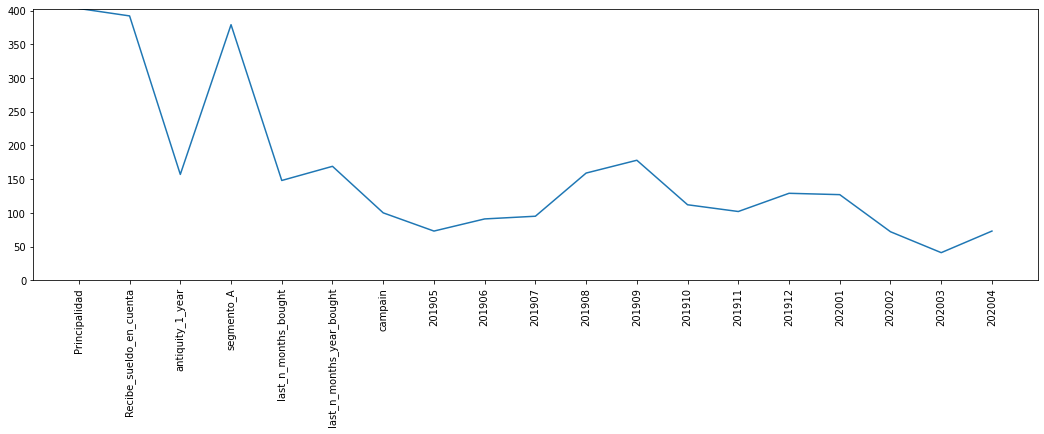

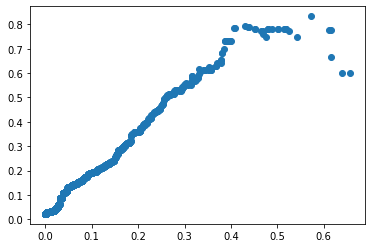

auc in train (do not metric for model) 0.6296232370608998
proporcion true 1 0.08969184928148455
proporcion prediccion 0.035039414626786856
acurracy in  train  0.9107481864242698
unbalanced acurracy in  train  0.5028953109230627
precision in  train  0.8571428571428571
***********************************************************************************
***********************************************************************************


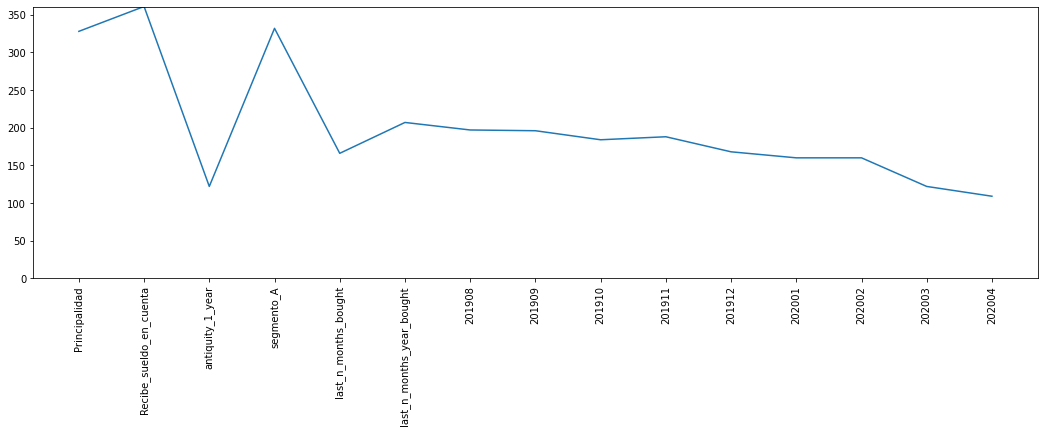

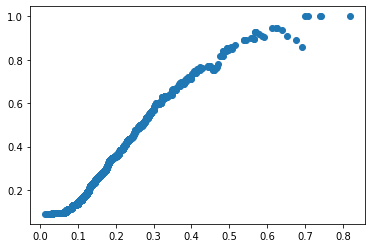

auc in train (do not metric for model) 0.9783992224718804
proporcion true 1 0.20674134701215754
proporcion prediccion 0.28398647204516025
acurracy in  train  0.9553803794365029
unbalanced acurracy in  train  0.9192686374920198
precision in  train  0.9210474760007836
***********************************************************************************
***********************************************************************************


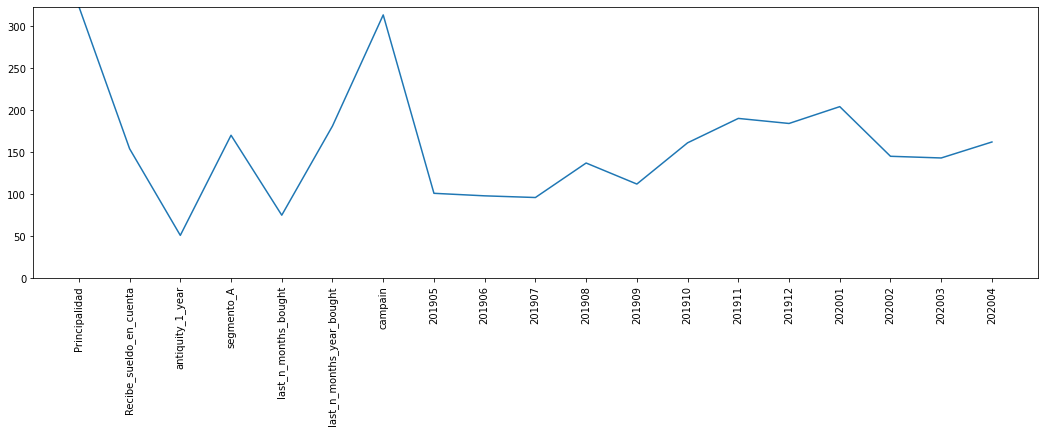

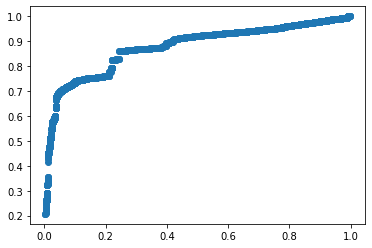

auc in train (do not metric for model) 0.8750077261531992
proporcion true 1 0.2960937401777744
proporcion prediccion 0.6105306830611398
acurracy in  train  0.8453840254466363
unbalanced acurracy in  train  0.7865696918645836
precision in  train  0.7960848287112561
***********************************************************************************
***********************************************************************************


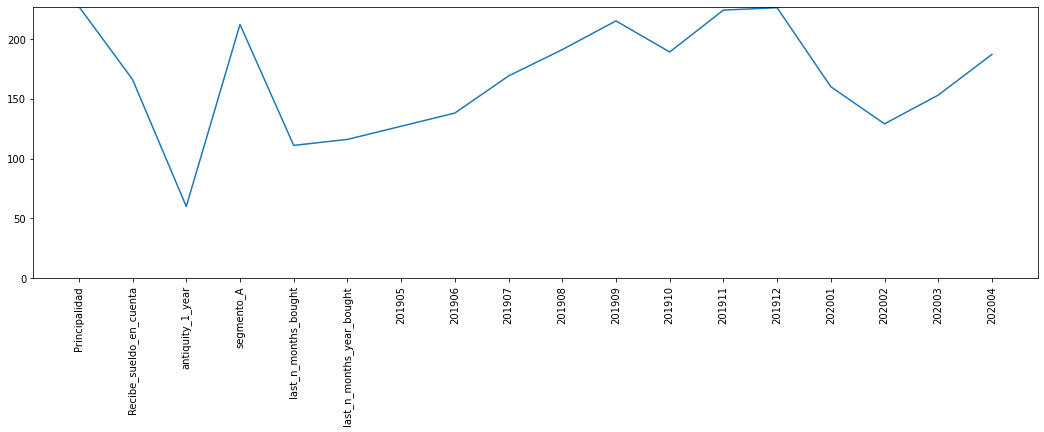

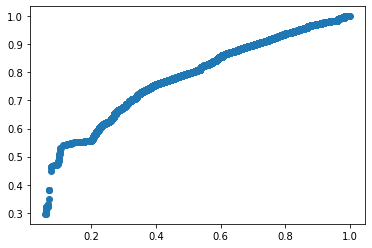

auc in train (do not metric for model) 0.8648317031459001
proporcion true 1 0.07006625680483788
proporcion prediccion 0.07288248532166611
acurracy in  train  0.9455487245250758
unbalanced acurracy in  train  0.6512501519907749
precision in  train  0.782016348773842
***********************************************************************************
***********************************************************************************


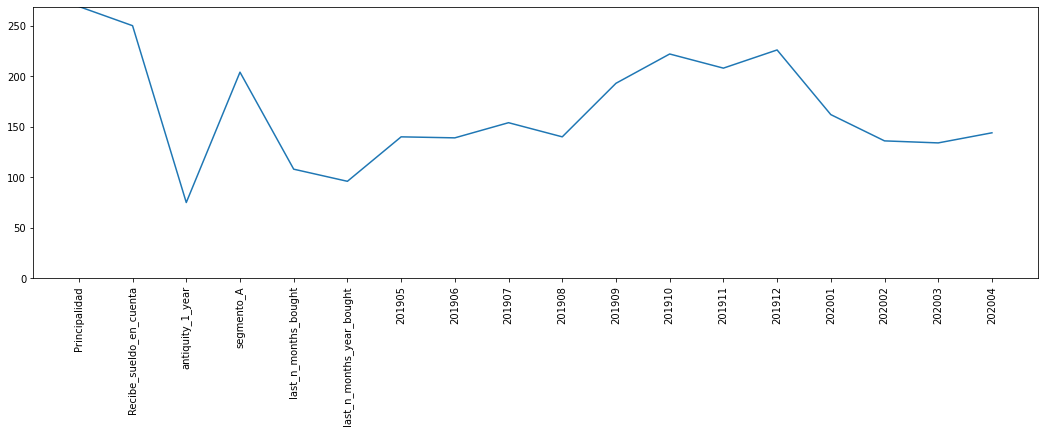

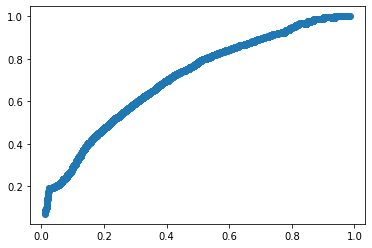

In [33]:

############## Model for A-A ############################################
for product in products:
  features_customers = ['id','Principalidad','Segmento_consumidor','Recibe_sueldo_en_cuenta','Meses_antiguedad']
  features_customers_df = get_features_customers(ds.customers_df,features_customers)

  df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)

  data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product,
                                                  list_last_months = list_3_last_months_train, list_last_year_months = list_last_year_3_months_train)
  data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product, 
                                                  list_last_months = list_3_last_months_test, list_last_year_months = list_last_year_3_months_test)

  if product in ['A-A','C-D']:
    data_train_nas = get_data_campains(ds.campains_train_df, data_train_out_campains, list_3_months_labels_train, product)
    data_test_nas  = get_data_campains(ds.campains_test_df, data_test_out_campains, list_3_months_campain_test, product)
  else:
    data_train_nas = data_train_out_campains
    data_test_nas = data_test_out_campains
  data_train = fill_na_data(data_train_nas)
  data_test = fill_na_data(data_test_nas)

  if product == 'B-B':
    mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201907)
    mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201910)
  else:
    mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201904)
    mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201907)
  months_features_train = get_months_features(df_transactions_product, data_train, mask_train)
  months_features_test = get_months_features(df_transactions_product, data_test, mask_test)

  data_train = data_train.merge(months_features_train,how='left',on='id')
  data_test = data_test.merge(months_features_test,how='left',on='id')

  df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
  X_train = data_train.drop(columns='id')
  X_test  = data_test.drop(columns='id')
  y = df_labels['labels']
  params = {'n_estimators': 100,'max_depth': 15}
  model = LGBMClassifier()
  model.fit(X_train,y)
  print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))

  percen = (1-sum(df_labels.labels)/len(df_labels))
  q = np.quantile(model.predict_proba(X_test)[:,1], percen) + dic_deltas[product]

  if product =='A-A':
    ids_entrega = pd.DataFrame(data = data_test.id)                    ################## only in A-A delete in others

  predict_proba_train = model.predict_proba(X_train)[:,1]
  predict_proba_test  = model.predict_proba(X_test)[:,1]
  dic_scores = precision_treshold_based_score(predict_proba_test, predict_proba_train,y)
  prec_base = sum(y)/len(y)
  ids_entrega.at[:,product] = [dic_scores[x]-prec_base for x in predict_proba_test ]   ###  
  #ids_entrega.at[:,product] = model.predict(X_test)

  y_pred = model.predict(X_train)

  print('proporcion true 1',sum(df_labels.labels)/len(df_labels))
  print('proporcion prediccion', sum(ids_entrega[product]>dic_epsilons_1[product])/len(ids_entrega))
  print('acurracy in  train ',accuracy_score(y,y_pred))
  print('unbalanced acurracy in  train ',balanced_accuracy_score(y,y_pred))
  print('precision in  train ',precision_score(y,y_pred))
  print('***********************************************************************************')
  print('***********************************************************************************')
  plt.figure(figsize=(18,5))
  plt.plot(model.feature_importances_)
  plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
  plt.ylim(0,max(model.feature_importances_))
  plt.show()
  #plt.hist(model.predict_proba(X_train)[:,1],bins=50)
  plt.scatter(x=list(dic_scores.keys()),y=list(dic_scores.values()))
  plt.show()

In [32]:
product

'D-E'

### Model B-B

auc in train (do not metric for model) 0.5853251731477188
proporcion true 1 0.08969184928148455
proporcion prediccion 0.01939928839940155
acurracy in  train  0.9106978966293265
precision in  train  0.8163265306122449
***********************************************************************************
***********************************************************************************


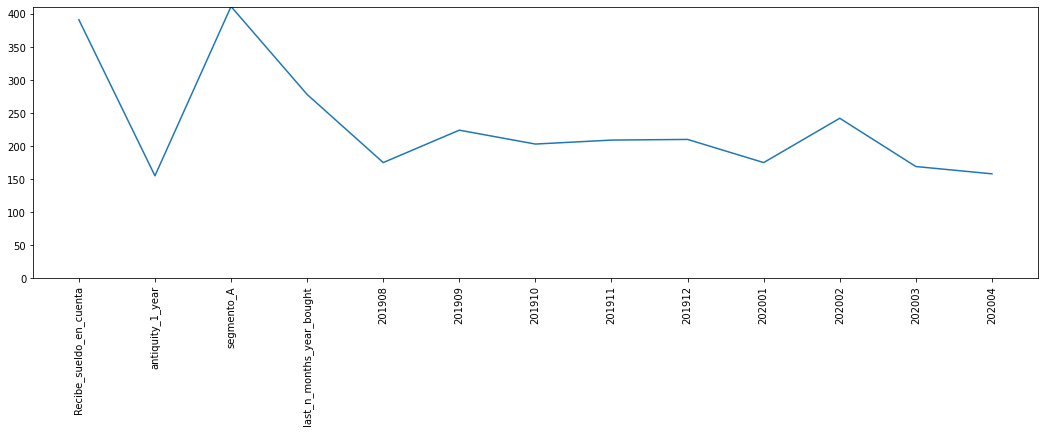

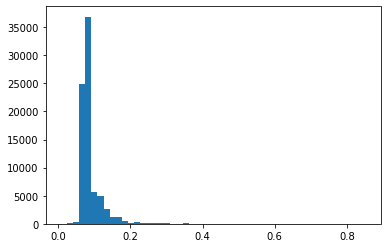

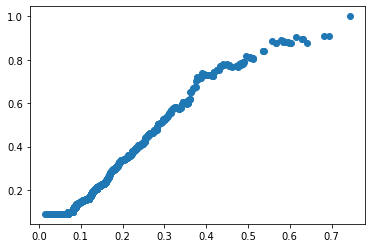

In [19]:
product = 'B-B'
features_customers = ['id','Segmento_consumidor','Recibe_sueldo_en_cuenta','Meses_antiguedad']
features_customers_df = get_features_customers(ds.customers_df,features_customers)

df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)

data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product, list_last_year_months = list_last_year_3_months_train)
data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product, list_last_year_months = list_last_year_3_months_test)

data_train_nas = data_train_out_campains
data_test_nas  = data_test_out_campains

data_train = fill_na_data(data_train_nas)
data_test = fill_na_data(data_test_nas)

mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201907)
mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201910)
months_features_train = get_months_features(df_transactions_product, data_train, mask_train)
months_features_test = get_months_features(df_transactions_product, data_test, mask_test)

data_train = data_train.merge(months_features_train,how='left',on='id')
data_test = data_test.merge(months_features_test,how='left',on='id')

df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
X_train = data_train.drop(columns='id')
X_test  = data_test.drop(columns='id')
y = df_labels['labels']
params = {'n_estimators': 75,'max_depth': 35}
model = LGBMClassifier()
model.fit(X_train,y)
print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))

percen = (1-sum(df_labels.labels)/len(df_labels))
q = np.quantile(model.predict_proba(X_test)[:,1], percen) + dic_deltas[product]

predict_proba_train = model.predict_proba(X_train)[:,1]
predict_proba_test  = model.predict_proba(X_test)[:,1]
dic_scores = precision_treshold_based_score(predict_proba_test, predict_proba_train,y)
prec_base = sum(y)/len(y)
ids_entrega.at[:,product] = [dic_scores[x]-prec_base for x in predict_proba_test ]   ###  
#ids_entrega.at[:,product] = model.predict(X_test)

y_pred = model.predict(X_train)
print('proporcion true 1',sum(df_labels.labels)/len(df_labels))
print('proporcion prediccion', sum(ids_entrega[product]>dic_epsilons_1[product])/len(ids_entrega))
print('acurracy in  train ',accuracy_score(y,y_pred))
print('precision in  train ',precision_score(y,y_pred))
print('***********************************************************************************')
print('***********************************************************************************')
plt.figure(figsize=(18,5))
plt.plot(model.feature_importances_)
plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
plt.ylim(0,max(model.feature_importances_))
plt.show()
plt.hist(model.predict_proba(X_train)[:,1],bins=50)
plt.show()
plt.scatter(x=list(dic_scores.keys()),y=list(dic_scores.values()))

### Model C-D

auc in train (do not metric for model) 0.9274327386496317
proporcion true 1 0.20674134701215754
proporcion prediccion 0.22054589572411018
acurracy in  train  0.9492450244534127
precision in  train  0.9133186754613898
***********************************************************************************
***********************************************************************************


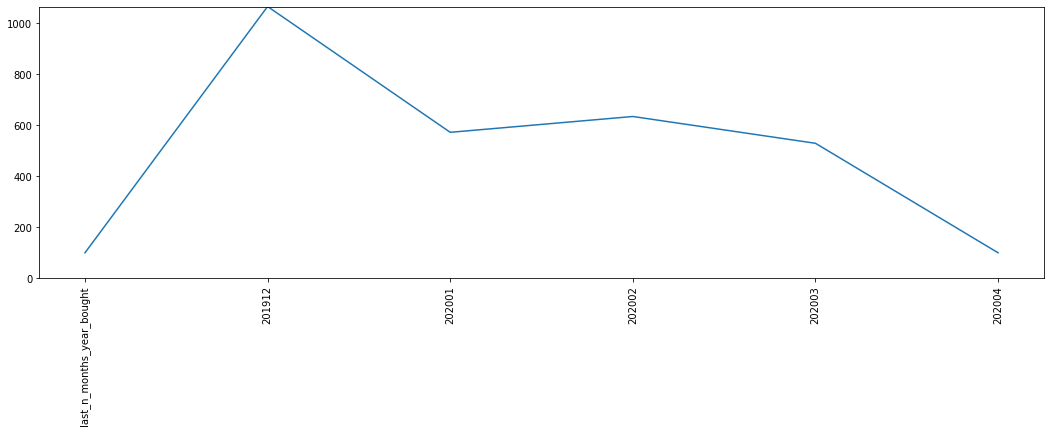

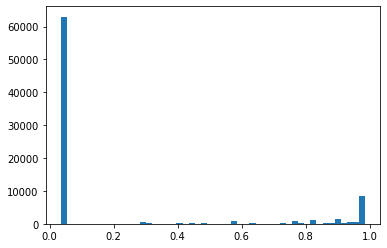

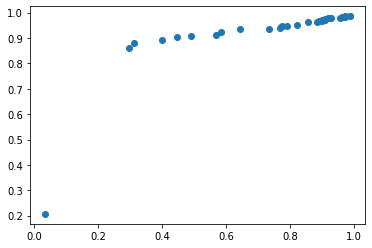

In [20]:
product = 'C-D'
features_customers = ['id','Segmento_consumidor']
features_customers_df = get_features_customers(ds.customers_df,features_customers)

df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)

data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product, list_last_months = list_3_last_months_train)
data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product, list_last_months = list_3_last_months_test)

data_train_nas = data_train_out_campains
data_test_nas  = data_test_out_campains

data_train = fill_na_data(data_train_nas)
data_test = fill_na_data(data_test_nas)

mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201911)
mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 202002)
months_features_train = get_months_features(df_transactions_product, data_train, mask_train)
months_features_test = get_months_features(df_transactions_product, data_test, mask_test)

data_train = data_train.merge(months_features_train,how='left',on='id')
data_train.drop(columns='segmento_A',inplace = True)
data_test = data_test.merge(months_features_test,how='left',on='id')
data_test.drop(columns='segmento_A',inplace = True)

df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
X_train = data_train.drop(columns='id')
X_test  = data_test.drop(columns='id')
y = df_labels['labels']
params = {'n_estimators': 75,'max_depth': 35}
model = LGBMClassifier()
model.fit(X_train,y)
print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))

percen = (1-sum(df_labels.labels)/len(df_labels))
q = np.quantile(model.predict_proba(X_test)[:,1], percen) + dic_deltas[product]


predict_proba_train = model.predict_proba(X_train)[:,1]
predict_proba_test  = model.predict_proba(X_test)[:,1]
dic_scores = precision_treshold_based_score(predict_proba_test, predict_proba_train,y)
prec_base = sum(y)/len(y)
ids_entrega.at[:,product] = [dic_scores[x]-prec_base for x in predict_proba_test ]   ###  
#ids_entrega.at[:,product] = model.predict(X_test)

y_pred = model.predict(X_train)
print('proporcion true 1',sum(df_labels.labels)/len(df_labels))
print('proporcion prediccion', sum(ids_entrega[product]>dic_epsilons_1[product])/len(ids_entrega))
print('acurracy in  train ',accuracy_score(y,y_pred))
print('precision in  train ',precision_score(y,y_pred))
print('***********************************************************************************')
print('***********************************************************************************')
plt.figure(figsize=(18,5))
plt.plot(model.feature_importances_)
plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
plt.ylim(0,max(model.feature_importances_))
plt.show()
plt.hist(model.predict_proba(X_train)[:,1],bins=50)
plt.show()
plt.scatter(x=list(dic_scores.keys()),y=list(dic_scores.values()))

### Model D-E

auc in train (do not metric for model) 0.8526763290023263
proporcion true 1 0.2960937401777744
proporcion prediccion 0.44618363318623566
acurracy in  train  0.8398521480028666
precision in  train  0.7838802835389866
***********************************************************************************
***********************************************************************************


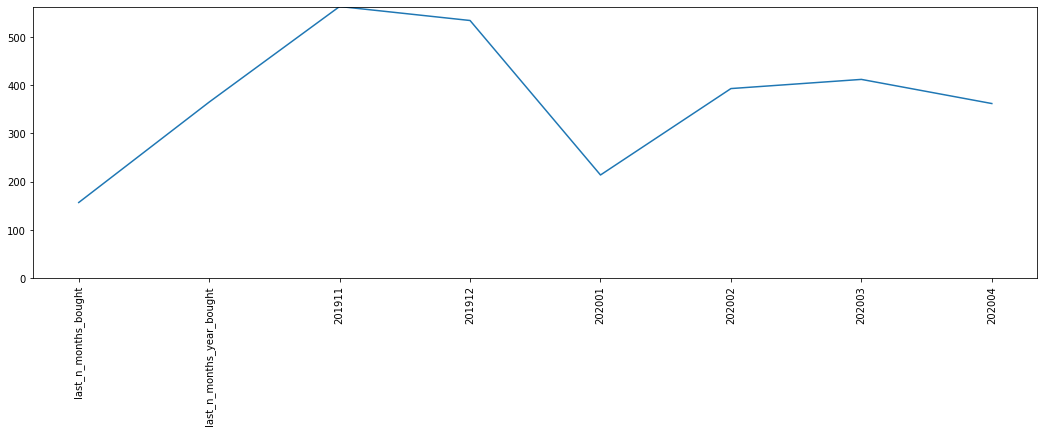

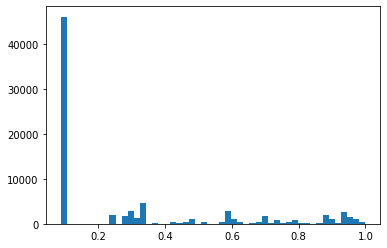

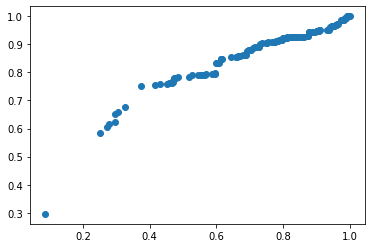

In [21]:
product = 'D-E'
features_customers = ['id','Segmento_consumidor']
features_customers_df = get_features_customers(ds.customers_df,features_customers)

df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)

data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product,
                                                list_last_months = list_3_last_months_train, list_last_year_months = list_last_year_3_months_train)
data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product, 
                                                list_last_months = list_3_last_months_test, list_last_year_months = list_last_year_3_months_test)

data_train_nas = data_train_out_campains
data_test_nas  = data_test_out_campains

data_train = fill_na_data(data_train_nas)
data_test = fill_na_data(data_test_nas)

mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201910)
mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 202001)
months_features_train = get_months_features(df_transactions_product, data_train, mask_train)
months_features_test = get_months_features(df_transactions_product, data_test, mask_test)

data_train = data_train.merge(months_features_train,how='left',on='id')
data_train.drop(columns='segmento_A',inplace = True)
data_test = data_test.merge(months_features_test,how='left',on='id')
data_test.drop(columns='segmento_A',inplace = True)

df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
X_train = data_train.drop(columns='id')
X_test  = data_test.drop(columns='id')
y = df_labels['labels']
params = {'n_estimators': 75,'max_depth': 35}
model = LGBMClassifier()
model.fit(X_train,y)
print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))

percen = (1-sum(df_labels.labels)/len(df_labels))
q = np.quantile(model.predict_proba(X_test)[:,1], percen) + dic_deltas[product]

predict_proba_train = model.predict_proba(X_train)[:,1]
predict_proba_test  = model.predict_proba(X_test)[:,1]
dic_scores = precision_treshold_based_score(predict_proba_test, predict_proba_train,y)
prec_base = sum(y)/len(y)
ids_entrega.at[:,product] = [dic_scores[x]-prec_base for x in predict_proba_test ]   ###    
#ids_entrega.at[:,product] = model.predict(X_test)

y_pred = model.predict(X_train)
print('proporcion true 1',sum(df_labels.labels)/len(df_labels))
print('proporcion prediccion', sum(ids_entrega[product]>+dic_epsilons_1[product])/len(ids_entrega))
print('acurracy in  train ',accuracy_score(y,y_pred))
print('precision in  train ',precision_score(y,y_pred))
print('***********************************************************************************')
print('***********************************************************************************')
plt.figure(figsize=(18,5))
plt.plot(model.feature_importances_)
plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
plt.ylim(0,max(model.feature_importances_))
plt.show()
plt.hist(model.predict_proba(X_train)[:,1],bins=50)
plt.show()
plt.scatter(x=list(dic_scores.keys()),y=list(dic_scores.values()))

### Model E-E

auc in train (do not metric for model) 0.8576428239377242
proporcion true 1 0.07006625680483788
proporcion prediccion 0.06760205685261318
acurracy in  train  0.9448698122933403
precision in  train  0.7709854014598541
***********************************************************************************
***********************************************************************************


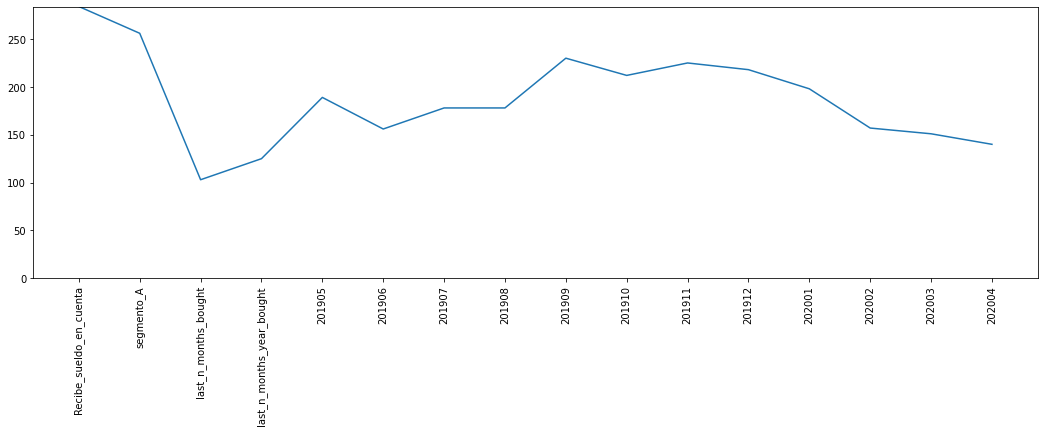

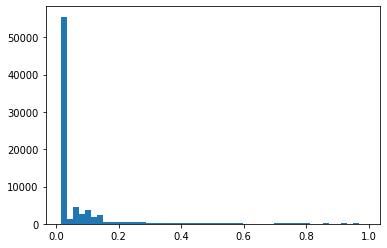

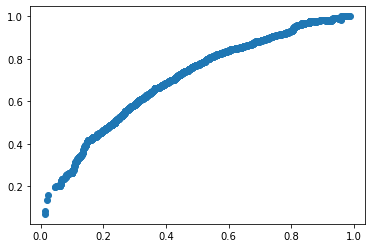

In [22]:
product = 'E-E'
features_customers = ['id','Segmento_consumidor','Recibe_sueldo_en_cuenta']
features_customers_df = get_features_customers(ds.customers_df,features_customers)

df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)

data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product,
                                                list_last_months = list_3_last_months_train, list_last_year_months = list_last_year_3_months_train)
data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product, 
                                                list_last_months = list_3_last_months_test, list_last_year_months = list_last_year_3_months_test)

data_train_nas = data_train_out_campains
data_test_nas  = data_test_out_campains

data_train = fill_na_data(data_train_nas)
data_test = fill_na_data(data_test_nas)

mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201904)
mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201907)
months_features_train = get_months_features(df_transactions_product, data_train, mask_train)
months_features_test = get_months_features(df_transactions_product, data_test, mask_test)

data_train = data_train.merge(months_features_train,how='left',on='id')
data_test = data_test.merge(months_features_test,how='left',on='id')

df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
X_train = data_train.drop(columns='id')
X_test  = data_test.drop(columns='id')
y = df_labels['labels']
params = {'n_estimators': 100,'max_depth': 15}
model = LGBMClassifier()
model.fit(X_train,y)
print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))

percen = (1-sum(df_labels.labels)/len(df_labels))
q = np.quantile(model.predict_proba(X_test)[:,1], percen) + dic_deltas[product]

predict_proba_train = model.predict_proba(X_train)[:,1]
predict_proba_test  = model.predict_proba(X_test)[:,1]
dic_scores = precision_treshold_based_score(predict_proba_test, predict_proba_train,y)
prec_base = sum(y)/len(y)
ids_entrega.at[:,product] = [dic_scores[x]-prec_base for x in predict_proba_test ]   ###  
#ids_entrega.at[:,product] = model.predict(X_test)

y_pred = model.predict(X_train)
print('proporcion true 1',sum(df_labels.labels)/len(df_labels))
print('proporcion prediccion', sum(ids_entrega[product]>dic_epsilons_1[product])/len(ids_entrega))
print('acurracy in  train ',accuracy_score(y, y_pred))
print('precision in  train ',precision_score(y, y_pred))
print('***********************************************************************************')
print('***********************************************************************************')
plt.figure(figsize=(18,5))
plt.plot(model.feature_importances_)
plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
plt.ylim(0,max(model.feature_importances_))
plt.show()
plt.hist(model.predict_proba(X_train)[:,1],bins=50)
plt.show()
plt.scatter(x=list(dic_scores.keys()),y=list(dic_scores.values()))

# Grid search random forest

## grid search

### Model A-A

auc in train (do not metric for model) 0.7527167821198638
proporcion true 1 0.022391531198531538
proporcion prediccion 0.005129559084222834
acurracy in  train  0.9780610769559587
precision in  train  0.7903225806451613
***********************************************************************************
***********************************************************************************


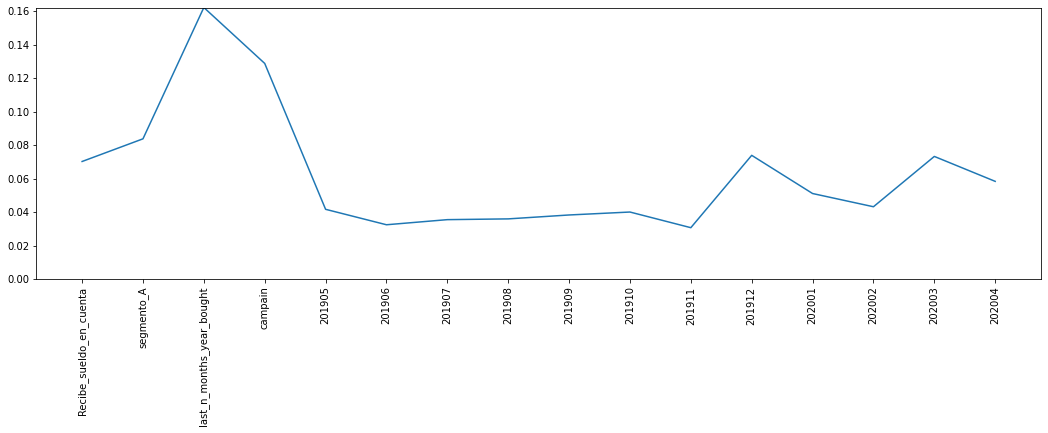

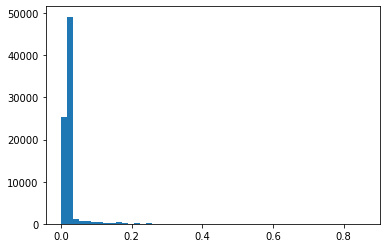

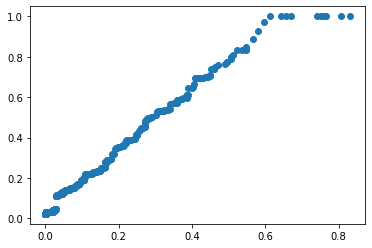

In [ ]:

############## Model for A-A ############################################
product = 'A-A'
features_customers = ['id','Segmento_consumidor','Recibe_sueldo_en_cuenta']
features_customers_df = get_features_customers(ds.customers_df,features_customers)

df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)

data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product, list_last_months = list_3_last_months_train)
data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product, list_last_months = list_3_last_months_test)

data_train_nas = get_data_campains(ds.campains_train_df, data_train_out_campains, list_3_months_labels_train, product)
data_test_nas  = get_data_campains(ds.campains_test_df, data_test_out_campains, list_3_months_campain_test, product)

data_train = fill_na_data(data_train_nas)
data_test = fill_na_data(data_test_nas)

mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201904)
mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201907)
months_features_train = get_months_features(df_transactions_product, data_train, mask_train)
months_features_test = get_months_features(df_transactions_product, data_test, mask_test)

data_train = data_train.merge(months_features_train,how='left',on='id')
data_test = data_test.merge(months_features_test,how='left',on='id')

df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
X_train = data_train.drop(columns='id')
X_test  = data_test.drop(columns='id')
y = df_labels['labels']

params = {'n_estimators': 100,'max_depth': 15}
estimator = RandomForestClassifier() 
model = GridSearchCV(svc, params,scoring = 'roc_auc')
model.fit(X_train,y)
print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))

percen = (1-sum(df_labels.labels)/len(df_labels))
q = np.quantile(model.predict_proba(X_test)[:,1], percen) + dic_deltas[product]

ids_entrega = pd.DataFrame(data = data_test.id)                    ################## only in A-A delete in others

predict_proba_train = model.predict_proba(X_train)[:,1]
predict_proba_test  = model.predict_proba(X_test)[:,1]
dic_scores = precision_treshold_based_score(predict_proba_test, predict_proba_train,y)
prec_base = sum(y)/len(y)
ids_entrega.at[:,product] = [dic_scores[x]-prec_base for x in predict_proba_test ]   ###  
#ids_entrega.at[:,product] = model.predict(X_test)

y_pred = model.predict(X_train)

print('proporcion true 1',sum(df_labels.labels)/len(df_labels))
print('proporcion prediccion', sum(ids_entrega[product]>dic_epsilons_1[product])/len(ids_entrega))
print('acurracy in  train ',accuracy_score(y,y_pred))
print('precision in  train ',precision_score(y,y_pred))
print('***********************************************************************************')
print('***********************************************************************************')
"""
plt.figure(figsize=(18,5))
plt.plot(model.feature_importances_)
plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
plt.ylim(0,max(model.feature_importances_))
plt.show()
plt.hist(model.predict_proba(X_train)[:,1],bins=50)
plt.show()
"""
plt.scatter(x=list(dic_scores.keys()),y=list(dic_scores.values()))
plt.show()

### Model B-B

auc in train (do not metric for model) 0.5967594032469333
proporcion true 1 0.08969184928148455
proporcion prediccion 0.028124567822074707
acurracy in  train  0.9122443078238348
precision in  train  0.8811881188118812
***********************************************************************************
***********************************************************************************


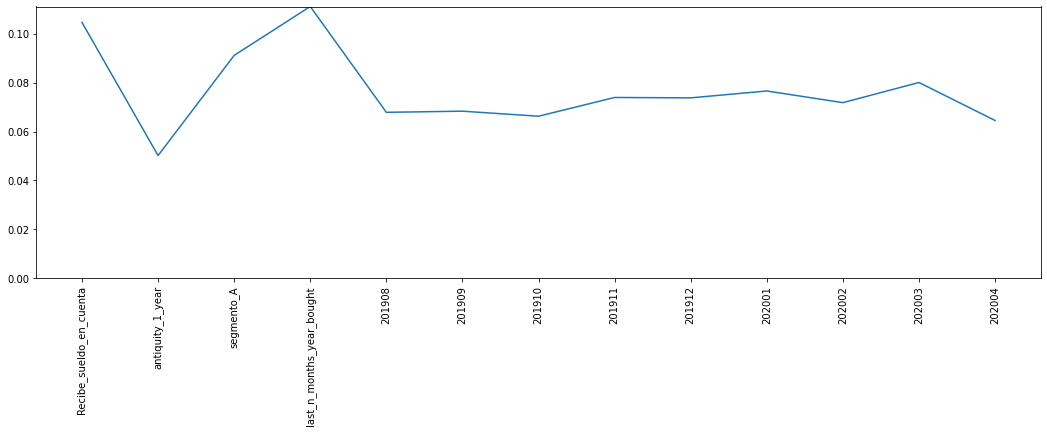

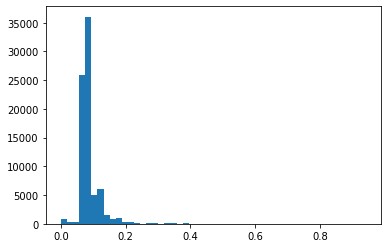

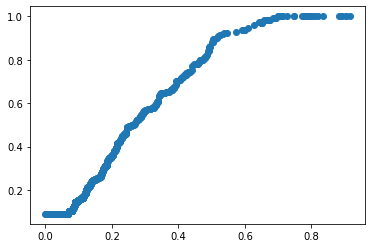

In [ ]:
product = 'B-B'
features_customers = ['id','Segmento_consumidor','Recibe_sueldo_en_cuenta','Meses_antiguedad']
features_customers_df = get_features_customers(ds.customers_df,features_customers)

df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)

data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product, list_last_year_months = list_last_year_3_months_train)
data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product, list_last_year_months = list_last_year_3_months_test)

data_train_nas = data_train_out_campains
data_test_nas  = data_test_out_campains

data_train = fill_na_data(data_train_nas)
data_test = fill_na_data(data_test_nas)

mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201907)
mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201910)
months_features_train = get_months_features(df_transactions_product, data_train, mask_train)
months_features_test = get_months_features(df_transactions_product, data_test, mask_test)

data_train = data_train.merge(months_features_train,how='left',on='id')
data_test = data_test.merge(months_features_test,how='left',on='id')

df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
X_train = data_train.drop(columns='id')
X_test  = data_test.drop(columns='id')
y = df_labels['labels']
params = {'n_estimators': 75,'max_depth': 35}
model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
model.fit(X_train,y)
print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))

percen = (1-sum(df_labels.labels)/len(df_labels))
q = np.quantile(model.predict_proba(X_test)[:,1], percen) + dic_deltas[product]

predict_proba_train = model.predict_proba(X_train)[:,1]
predict_proba_test  = model.predict_proba(X_test)[:,1]
dic_scores = precision_treshold_based_score(predict_proba_test, predict_proba_train,y)
prec_base = sum(y)/len(y)
ids_entrega.at[:,product] = [dic_scores[x]-prec_base for x in predict_proba_test ]   ###  
#ids_entrega.at[:,product] = model.predict(X_test)

y_pred = model.predict(X_train)
print('proporcion true 1',sum(df_labels.labels)/len(df_labels))
print('proporcion prediccion', sum(ids_entrega[product]>dic_epsilons_1[product])/len(ids_entrega))
print('acurracy in  train ',accuracy_score(y,y_pred))
print('precision in  train ',precision_score(y,y_pred))
print('***********************************************************************************')
print('***********************************************************************************')
plt.figure(figsize=(18,5))
plt.plot(model.feature_importances_)
plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
plt.ylim(0,max(model.feature_importances_))
plt.show()
plt.hist(model.predict_proba(X_train)[:,1],bins=50)
plt.show()
plt.scatter(x=list(dic_scores.keys()),y=list(dic_scores.values()))

### Model C-D

auc in train (do not metric for model) 0.9274322808333889
proporcion true 1 0.20674134701215754
proporcion prediccion 0.22054589572411018
acurracy in  train  0.9492450244534127
precision in  train  0.9133186754613898
***********************************************************************************
***********************************************************************************


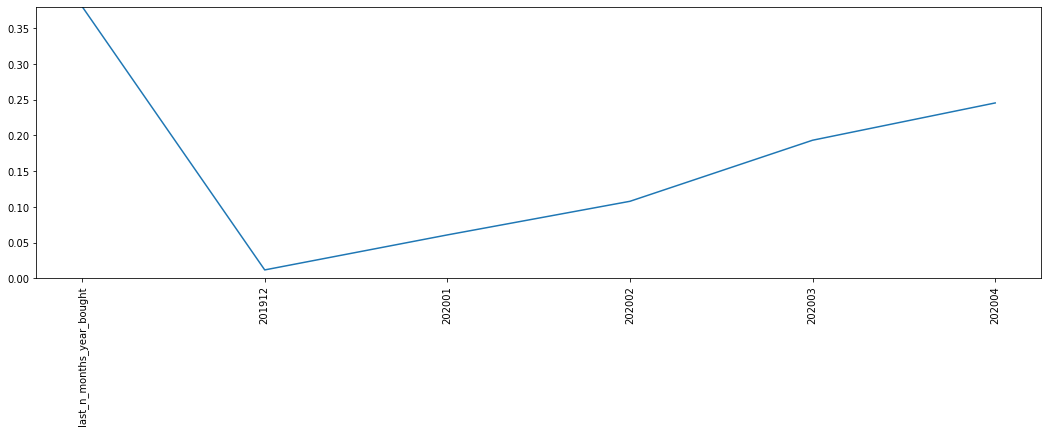

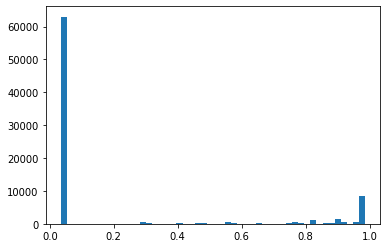

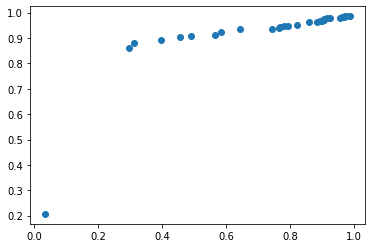

In [ ]:
product = 'C-D'
features_customers = ['id','Segmento_consumidor']
features_customers_df = get_features_customers(ds.customers_df,features_customers)

df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)

data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product, list_last_months = list_3_last_months_train)
data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product, list_last_months = list_3_last_months_test)

data_train_nas = data_train_out_campains
data_test_nas  = data_test_out_campains

data_train = fill_na_data(data_train_nas)
data_test = fill_na_data(data_test_nas)

mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201911)
mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 202002)
months_features_train = get_months_features(df_transactions_product, data_train, mask_train)
months_features_test = get_months_features(df_transactions_product, data_test, mask_test)

data_train = data_train.merge(months_features_train,how='left',on='id')
data_train.drop(columns='segmento_A',inplace = True)
data_test = data_test.merge(months_features_test,how='left',on='id')
data_test.drop(columns='segmento_A',inplace = True)

df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
X_train = data_train.drop(columns='id')
X_test  = data_test.drop(columns='id')
y = df_labels['labels']
params = {'n_estimators': 75,'max_depth': 35}
model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
model.fit(X_train,y)
print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))

percen = (1-sum(df_labels.labels)/len(df_labels))
q = np.quantile(model.predict_proba(X_test)[:,1], percen) + dic_deltas[product]


predict_proba_train = model.predict_proba(X_train)[:,1]
predict_proba_test  = model.predict_proba(X_test)[:,1]
dic_scores = precision_treshold_based_score(predict_proba_test, predict_proba_train,y)
prec_base = sum(y)/len(y)
ids_entrega.at[:,product] = [dic_scores[x]-prec_base for x in predict_proba_test ]   ###  
#ids_entrega.at[:,product] = model.predict(X_test)

y_pred = model.predict(X_train)
print('proporcion true 1',sum(df_labels.labels)/len(df_labels))
print('proporcion prediccion', sum(ids_entrega[product]>dic_epsilons_1[product])/len(ids_entrega))
print('acurracy in  train ',accuracy_score(y,y_pred))
print('precision in  train ',precision_score(y,y_pred))
print('***********************************************************************************')
print('***********************************************************************************')
plt.figure(figsize=(18,5))
plt.plot(model.feature_importances_)
plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
plt.ylim(0,max(model.feature_importances_))
plt.show()
plt.hist(model.predict_proba(X_train)[:,1],bins=50)
plt.show()
plt.scatter(x=list(dic_scores.keys()),y=list(dic_scores.values()))

### Model D-E

auc in train (do not metric for model) 0.8526813473047282
proporcion true 1 0.2960937401777744
proporcion prediccion 0.44618363318623566
acurracy in  train  0.8398521480028666
precision in  train  0.7838802835389866
***********************************************************************************
***********************************************************************************


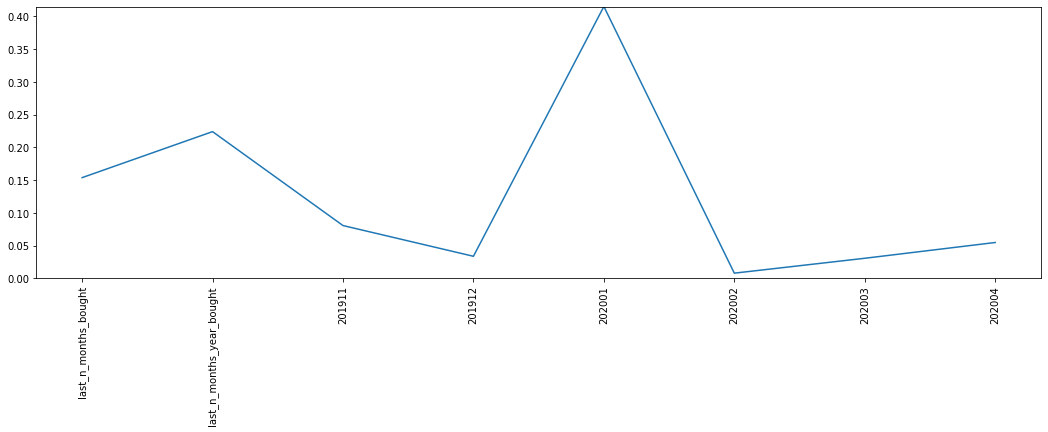

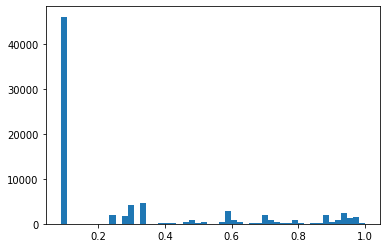

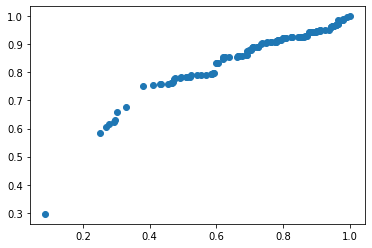

In [ ]:
product = 'D-E'
features_customers = ['id','Segmento_consumidor']
features_customers_df = get_features_customers(ds.customers_df,features_customers)

df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)

data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product,
                                                list_last_months = list_3_last_months_train, list_last_year_months = list_last_year_3_months_train)
data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product, 
                                                list_last_months = list_3_last_months_test, list_last_year_months = list_last_year_3_months_test)

data_train_nas = data_train_out_campains
data_test_nas  = data_test_out_campains

data_train = fill_na_data(data_train_nas)
data_test = fill_na_data(data_test_nas)

mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201910)
mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 202001)
months_features_train = get_months_features(df_transactions_product, data_train, mask_train)
months_features_test = get_months_features(df_transactions_product, data_test, mask_test)

data_train = data_train.merge(months_features_train,how='left',on='id')
data_train.drop(columns='segmento_A',inplace = True)
data_test = data_test.merge(months_features_test,how='left',on='id')
data_test.drop(columns='segmento_A',inplace = True)

df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
X_train = data_train.drop(columns='id')
X_test  = data_test.drop(columns='id')
y = df_labels['labels']
params = {'n_estimators': 75,'max_depth': 35}
model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
model.fit(X_train,y)
print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))

percen = (1-sum(df_labels.labels)/len(df_labels))
q = np.quantile(model.predict_proba(X_test)[:,1], percen) + dic_deltas[product]

predict_proba_train = model.predict_proba(X_train)[:,1]
predict_proba_test  = model.predict_proba(X_test)[:,1]
dic_scores = precision_treshold_based_score(predict_proba_test, predict_proba_train,y)
prec_base = sum(y)/len(y)
ids_entrega.at[:,product] = [dic_scores[x]-prec_base for x in predict_proba_test ]   ###    
#ids_entrega.at[:,product] = model.predict(X_test)

y_pred = model.predict(X_train)
print('proporcion true 1',sum(df_labels.labels)/len(df_labels))
print('proporcion prediccion', sum(ids_entrega[product]>+dic_epsilons_1[product])/len(ids_entrega))
print('acurracy in  train ',accuracy_score(y,y_pred))
print('precision in  train ',precision_score(y,y_pred))
print('***********************************************************************************')
print('***********************************************************************************')
plt.figure(figsize=(18,5))
plt.plot(model.feature_importances_)
plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
plt.ylim(0,max(model.feature_importances_))
plt.show()
plt.hist(model.predict_proba(X_train)[:,1],bins=50)
plt.show()
plt.scatter(x=list(dic_scores.keys()),y=list(dic_scores.values()))

### Model E-E

auc in train (do not metric for model) 0.8665646806000199
proporcion true 1 0.07006625680483788
proporcion prediccion 0.08495203610807277
acurracy in  train  0.9509800223789587
precision in  train  0.8499163879598662
***********************************************************************************
***********************************************************************************


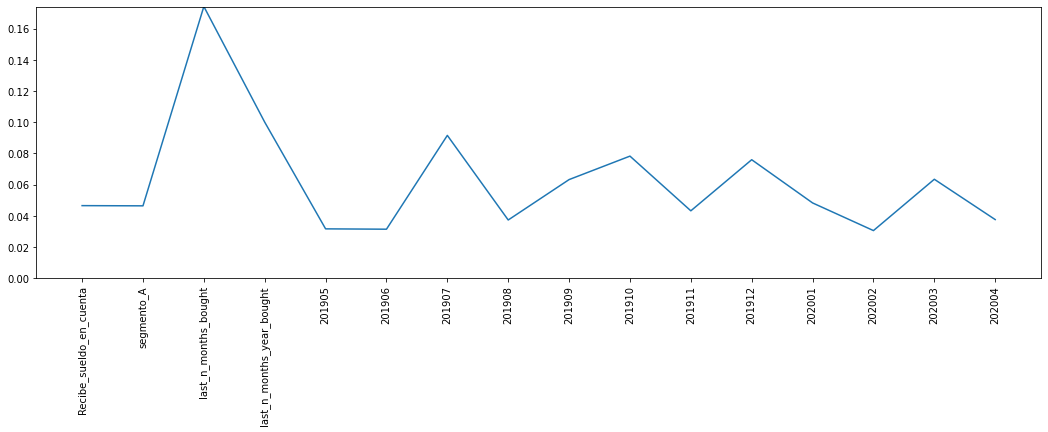

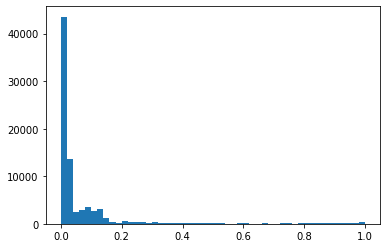

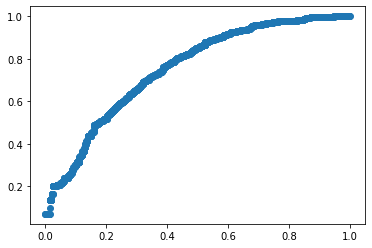

In [ ]:
product = 'E-E'
features_customers = ['id','Segmento_consumidor','Recibe_sueldo_en_cuenta']
features_customers_df = get_features_customers(ds.customers_df,features_customers)

df_transactions_product = get_df_transactions_product(ds.transactions_train_df, product)

data_train_out_campains = get_data_transactions(features_customers_df, df_transactions_product,
                                                list_last_months = list_3_last_months_train, list_last_year_months = list_last_year_3_months_train)
data_test_out_campains  = get_data_transactions(features_customers_df, df_transactions_product, 
                                                list_last_months = list_3_last_months_test, list_last_year_months = list_last_year_3_months_test)

data_train_nas = data_train_out_campains
data_test_nas  = data_test_out_campains

data_train = fill_na_data(data_train_nas)
data_test = fill_na_data(data_test_nas)

mask_train = (df_transactions_product.Periodo < 202005) & (df_transactions_product.Periodo > 201904)
mask_test = (df_transactions_product.Periodo < 202008)  & (df_transactions_product.Periodo > 201907)
months_features_train = get_months_features(df_transactions_product, data_train, mask_train)
months_features_test = get_months_features(df_transactions_product, data_test, mask_test)

data_train = data_train.merge(months_features_train,how='left',on='id')
data_test = data_test.merge(months_features_test,how='left',on='id')

df_labels = get_labels(df_transactions_product, features_customers_df, list_3_months_labels_train)
X_train = data_train.drop(columns='id')
X_test  = data_test.drop(columns='id')
y = df_labels['labels']
params = {'n_estimators': 100,'max_depth': 15}
model = RandomForestClassifier(n_estimators=params['n_estimators'], max_depth=params['max_depth'])
model.fit(X_train,y)
print('auc in train (do not metric for model)',roc_auc_score(y,model.predict_proba(X_train)[:,1]))

percen = (1-sum(df_labels.labels)/len(df_labels))
q = np.quantile(model.predict_proba(X_test)[:,1], percen) + dic_deltas[product]

predict_proba_train = model.predict_proba(X_train)[:,1]
predict_proba_test  = model.predict_proba(X_test)[:,1]
dic_scores = precision_treshold_based_score(predict_proba_test, predict_proba_train,y)
prec_base = sum(y)/len(y)
ids_entrega.at[:,product] = [dic_scores[x]-prec_base for x in predict_proba_test ]   ###  
#ids_entrega.at[:,product] = model.predict(X_test)

y_pred = model.predict(X_train)
print('proporcion true 1',sum(df_labels.labels)/len(df_labels))
print('proporcion prediccion', sum(ids_entrega[product]>dic_epsilons_1[product])/len(ids_entrega))
print('acurracy in  train ',accuracy_score(y, y_pred))
print('precision in  train ',precision_score(y, y_pred))
print('***********************************************************************************')
print('***********************************************************************************')
plt.figure(figsize=(18,5))
plt.plot(model.feature_importances_)
plt.xticks(ticks=range(len(model.feature_importances_)),labels=list(X_train.columns),rotation = 90)
plt.ylim(0,max(model.feature_importances_))
plt.show()
plt.hist(model.predict_proba(X_train)[:,1],bins=50)
plt.show()
plt.scatter(x=list(dic_scores.keys()),y=list(dic_scores.values()))

* without campains with 3 periods 46.87%

# Send

In [34]:
ids_entrega.reset_index(inplace=True)
products  = ["A-A", "B-B", "C-D", "D-E", "E-E"]
entrega_vals = pd.melt(ids_entrega,id_vars='id',value_vars=products)
entrega_vals.sort_values(by=['id','value'], ascending=[True,False],inplace=True)
entrega_df = entrega_vals.groupby('id').agg({'variable':list})
entrega_df['productos'] = [" ".join(x) for x in entrega_df["variable"]]

In [39]:
primera = pd.Series([lista[4] for lista in entrega_df.variable])
primera.value_counts()/len(primera)

A-A    0.508958
B-B    0.215957
E-E    0.190221
C-D    0.050240
D-E    0.034625
dtype: float64

In [40]:
from datetime import datetime
entrega_df.drop(columns='variable',inplace=True)
entrega_df
filename = ds.BASE_PATH/f'predictions/{datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}.csv'
entrega_df.to_csv(filename)